### Import dependencies :

In [1]:
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error , mean_absolute_error
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
import joblib

2025-07-01 16:17:19.355171: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-01 16:17:19.359973: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-01 16:17:19.375925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751379439.403252  282792 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751379439.410337  282792 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751379439.430680  282792 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### Load Data :

In [2]:
df_test=pd.read_csv('TEST_CASES.csv')
df_test

,Tg_scat,Tg_abs,AOD,SSA,g1,Z,Zenith_Angle,reflectance,k_a,k_g,gaz_model,dl,BOA_RT
0,0.700200,0.996600,0.443408,0.953056,0.899265,0,15,0.1,1,1,USSTD76,0.00,824.054809
1,0.705600,0.997200,0.441144,0.952816,0.898916,0,15,0.1,1,1,USSTD76,0.00,827.341584
2,0.710887,0.996500,0.438815,0.952798,0.898567,0,15,0.1,1,1,USSTD76,0.00,829.522785
3,0.716009,0.997491,0.436646,0.952797,0.898218,0,15,0.1,1,1,USSTD76,0.00,833.131225
4,0.721100,0.996700,0.434482,0.952797,0.897869,0,15,0.1,1,1,USSTD76,0.00,835.112198
...,...,...,...,...,...,...,...,...,...,...,...,...,...
647995,0.999800,0.021037,0.064186,0.822761,0.891463,1000,60,0.7,2,2,TROPICAL,0.06,8.340527
647996,0.999800,0.017364,0.064177,0.821566,0.891450,1000,60,0.7,2,2,TROPICAL,0.06,6.588968
647997,0.999800,0.016097,0.064170,0.820287,0.891422,1000,60,0.7,2,2,TROPICAL,0.06,6.003717
647998,0.999800,0.010019,0.064169,0.818911,0.891379,1000,60,0.7,2,2,TROPICAL,0.06,3.355994


### Prepare Data for evaluation :

In [3]:
def muprime(z,h,µ):
    RAYON_TERRESTRE=6371
    eta = (RAYON_TERRESTRE*1000 + z) / h
    root = (eta*µ)**2  + 2 * eta + 1
    sum = (root)**0.5 - eta * µ
    if sum > 0 :
        return 1/sum
    return 1 

In [4]:
def prepare_df(data):
    data['mu_g']=(6371*1000+data['Z'])/9000
    data['mu_a']=(6371*1000+data['Z'])/2000
    data['AODS']=data['AOD']*data['SSA']
    data['Cos(SZA)']=np.cos(np.radians(data['Zenith_Angle']))
    data['Ta_abs']=np.exp(-data['AOD']*(1-data['SSA']))
    data['muprime_g'] = data.apply(lambda row: muprime(row['Z'],9000,row['Cos(SZA)']), axis=1)
    data['muprime_a'] = data.apply(lambda row: muprime(row['Z'],2000,row['Cos(SZA)']), axis=1)
    data['mprime_g']=np.exp(-data['Z']/9000)/data['muprime_g']
    data['mprime_a']=np.exp(-data['Z']/2000)/data['muprime_a']
    data['GOD']=-np.log(data['Tg_scat'])
    data.rename(columns={'reflectance': 'R_scene'}, inplace=True)
    data.rename(columns={'Zenith_Angle': 'SZA'}, inplace=True)
    ordered_columns = [
        'Tg_scat', 'Tg_abs', 'Ta_abs', 'SSA', 'GOD', 'AOD', 'AODS', 'SZA', 'Z',
        'R_scene', 'g1', 'Cos(SZA)', 'mu_g', 'mu_a', 'muprime_g', 'muprime_a',
        'mprime_g', 'mprime_a', 'BOA_RT','k_a','k_g','gaz_model','dl'
    ]
    data = data[ordered_columns]
    return data

In [5]:
df_test=prepare_df(df_test)
df_test

,Tg_scat,Tg_abs,Ta_abs,SSA,GOD,AOD,AODS,SZA,Z,R_scene,...,mu_a,muprime_g,muprime_a,mprime_g,mprime_a,BOA_RT,k_a,k_g,gaz_model,dl
0,0.700200,0.996600,0.979400,0.953056,0.356389,0.443408,0.422593,15,0,0.1,...,3185.5,0.965975,0.965937,1.035224,1.035265,824.054809,1,1,USSTD76,0.00
1,0.705600,0.997200,0.979400,0.952816,0.348707,0.441144,0.420329,15,0,0.1,...,3185.5,0.965975,0.965937,1.035224,1.035265,827.341584,1,1,USSTD76,0.00
2,0.710887,0.996500,0.979500,0.952798,0.341241,0.438815,0.418102,15,0,0.1,...,3185.5,0.965975,0.965937,1.035224,1.035265,829.522785,1,1,USSTD76,0.00
3,0.716009,0.997491,0.979600,0.952797,0.334063,0.436646,0.416035,15,0,0.1,...,3185.5,0.965975,0.965937,1.035224,1.035265,833.131225,1,1,USSTD76,0.00
4,0.721100,0.996700,0.979700,0.952797,0.326977,0.434482,0.413973,15,0,0.1,...,3185.5,0.965975,0.965937,1.035224,1.035265,835.112198,1,1,USSTD76,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647995,0.999800,0.021037,0.988688,0.822761,0.000200,0.064186,0.052810,60,1000,0.7,...,3186.0,0.501056,0.500235,1.785908,1.212491,8.340527,2,2,TROPICAL,0.06
647996,0.999800,0.017364,0.988614,0.821566,0.000200,0.064177,0.052726,60,1000,0.7,...,3186.0,0.501056,0.500235,1.785908,1.212491,6.588968,2,2,TROPICAL,0.06
647997,0.999800,0.016097,0.988534,0.820287,0.000200,0.064170,0.052638,60,1000,0.7,...,3186.0,0.501056,0.500235,1.785908,1.212491,6.003717,2,2,TROPICAL,0.06
647998,0.999800,0.010019,0.988447,0.818911,0.000200,0.064169,0.052549,60,1000,0.7,...,3186.0,0.501056,0.500235,1.785908,1.212491,3.355994,2,2,TROPICAL,0.06


### Add Wave_Length column :

In [6]:
n_rows = 648000
n_period = 1000
periodic_values = np.linspace(0.4, 2.5, n_period)
repeated_values = np.tile(periodic_values, n_rows // n_period)
df_test['lamda'] = repeated_values

In [7]:
df_test

,Tg_scat,Tg_abs,Ta_abs,SSA,GOD,AOD,AODS,SZA,Z,R_scene,...,muprime_g,muprime_a,mprime_g,mprime_a,BOA_RT,k_a,k_g,gaz_model,dl,lamda
0,0.700200,0.996600,0.979400,0.953056,0.356389,0.443408,0.422593,15,0,0.1,...,0.965975,0.965937,1.035224,1.035265,824.054809,1,1,USSTD76,0.00,0.400000
1,0.705600,0.997200,0.979400,0.952816,0.348707,0.441144,0.420329,15,0,0.1,...,0.965975,0.965937,1.035224,1.035265,827.341584,1,1,USSTD76,0.00,0.402102
2,0.710887,0.996500,0.979500,0.952798,0.341241,0.438815,0.418102,15,0,0.1,...,0.965975,0.965937,1.035224,1.035265,829.522785,1,1,USSTD76,0.00,0.404204
3,0.716009,0.997491,0.979600,0.952797,0.334063,0.436646,0.416035,15,0,0.1,...,0.965975,0.965937,1.035224,1.035265,833.131225,1,1,USSTD76,0.00,0.406306
4,0.721100,0.996700,0.979700,0.952797,0.326977,0.434482,0.413973,15,0,0.1,...,0.965975,0.965937,1.035224,1.035265,835.112198,1,1,USSTD76,0.00,0.408408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647995,0.999800,0.021037,0.988688,0.822761,0.000200,0.064186,0.052810,60,1000,0.7,...,0.501056,0.500235,1.785908,1.212491,8.340527,2,2,TROPICAL,0.06,2.491592
647996,0.999800,0.017364,0.988614,0.821566,0.000200,0.064177,0.052726,60,1000,0.7,...,0.501056,0.500235,1.785908,1.212491,6.588968,2,2,TROPICAL,0.06,2.493694
647997,0.999800,0.016097,0.988534,0.820287,0.000200,0.064170,0.052638,60,1000,0.7,...,0.501056,0.500235,1.785908,1.212491,6.003717,2,2,TROPICAL,0.06,2.495796
647998,0.999800,0.010019,0.988447,0.818911,0.000200,0.064169,0.052549,60,1000,0.7,...,0.501056,0.500235,1.785908,1.212491,3.355994,2,2,TROPICAL,0.06,2.497898


### The Target variable :

In [8]:
df_test['BOA_fraction']=df_test['BOA_RT']/1000

### Pretraitement :

In [9]:
scaler=joblib.load('/home/fayari/Stage/modeling/scaler_SS_BOA_DART.pkl')
scaler_y=joblib.load('/home/fayari/Stage/modeling/scaler_y_SS_BOA_DART.pkl')

In [10]:
df_test

,Tg_scat,Tg_abs,Ta_abs,SSA,GOD,AOD,AODS,SZA,Z,R_scene,...,muprime_a,mprime_g,mprime_a,BOA_RT,k_a,k_g,gaz_model,dl,lamda,BOA_fraction
0,0.700200,0.996600,0.979400,0.953056,0.356389,0.443408,0.422593,15,0,0.1,...,0.965937,1.035224,1.035265,824.054809,1,1,USSTD76,0.00,0.400000,0.824055
1,0.705600,0.997200,0.979400,0.952816,0.348707,0.441144,0.420329,15,0,0.1,...,0.965937,1.035224,1.035265,827.341584,1,1,USSTD76,0.00,0.402102,0.827342
2,0.710887,0.996500,0.979500,0.952798,0.341241,0.438815,0.418102,15,0,0.1,...,0.965937,1.035224,1.035265,829.522785,1,1,USSTD76,0.00,0.404204,0.829523
3,0.716009,0.997491,0.979600,0.952797,0.334063,0.436646,0.416035,15,0,0.1,...,0.965937,1.035224,1.035265,833.131225,1,1,USSTD76,0.00,0.406306,0.833131
4,0.721100,0.996700,0.979700,0.952797,0.326977,0.434482,0.413973,15,0,0.1,...,0.965937,1.035224,1.035265,835.112198,1,1,USSTD76,0.00,0.408408,0.835112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647995,0.999800,0.021037,0.988688,0.822761,0.000200,0.064186,0.052810,60,1000,0.7,...,0.500235,1.785908,1.212491,8.340527,2,2,TROPICAL,0.06,2.491592,0.008341
647996,0.999800,0.017364,0.988614,0.821566,0.000200,0.064177,0.052726,60,1000,0.7,...,0.500235,1.785908,1.212491,6.588968,2,2,TROPICAL,0.06,2.493694,0.006589
647997,0.999800,0.016097,0.988534,0.820287,0.000200,0.064170,0.052638,60,1000,0.7,...,0.500235,1.785908,1.212491,6.003717,2,2,TROPICAL,0.06,2.495796,0.006004
647998,0.999800,0.010019,0.988447,0.818911,0.000200,0.064169,0.052549,60,1000,0.7,...,0.500235,1.785908,1.212491,3.355994,2,2,TROPICAL,0.06,2.497898,0.003356


In [11]:
cols_to_scale = df_test.drop(columns=['BOA_fraction','BOA_RT','lamda','dl','k_a','k_g','gaz_model']).columns

In [12]:
X_scaled = scaler.transform(df_test[cols_to_scale])
y_scaled=scaler_y.transform(df_test['BOA_fraction'].values.reshape(-1, 1))

### Load Model :

In [13]:
model=load_model('/home/fayari/Stage/modeling/deep_model_v2.h5', compile=False)

2025-07-01 16:17:39.736995: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [16]:
y_pred_scaled=model.predict(X_scaled)

20250/20250 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step


In [27]:
y_pred=scaler_y.inverse_transform(y_pred_scaled)
y_pred = np.clip(y_pred, a_min=0, a_max=None)

In [28]:
df_test['BOA_fraction_pred']=y_pred
df_test['BOA_pred']=df_test['BOA_fraction_pred']*1000

In [29]:
df_test

,Tg_scat,Tg_abs,Ta_abs,SSA,GOD,AOD,AODS,SZA,Z,R_scene,...,k_g,gaz_model,dl,lamda,BOA_fraction,BOA_fraction_pred,BOA_pred,BOA_Analytic,Erreur_AI,Erreur_Analytic
0,0.700200,0.996600,0.979400,0.953056,0.356389,0.443408,0.422593,15,0,0.1,...,1,USSTD76,0.00,0.400000,0.824055,0.825226,825.226013,775.606080,116.654969,48.448729
1,0.705600,0.997200,0.979400,0.952816,0.348707,0.441144,0.420329,15,0,0.1,...,1,USSTD76,0.00,0.402102,0.827342,0.828582,828.582153,778.794349,114.189239,48.547235
2,0.710887,0.996500,0.979500,0.952798,0.341241,0.438815,0.418102,15,0,0.1,...,1,USSTD76,0.00,0.404204,0.829523,0.830488,830.488220,780.958660,112.474407,48.564125
3,0.716009,0.997491,0.979600,0.952797,0.334063,0.436646,0.416035,15,0,0.1,...,1,USSTD76,0.00,0.406306,0.833131,0.834211,834.211426,784.403183,109.776795,48.728042
4,0.721100,0.996700,0.979700,0.952797,0.326977,0.434482,0.413973,15,0,0.1,...,1,USSTD76,0.00,0.408408,0.835112,0.835907,835.907471,786.383972,108.210739,48.728226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647995,0.999800,0.021037,0.988688,0.822761,0.000200,0.064186,0.052810,60,1000,0.7,...,2,TROPICAL,0.06,2.491592,0.008341,0.007662,7.662139,0.987027,911.230701,7.353500
647996,0.999800,0.017364,0.988614,0.821566,0.000200,0.064177,0.052726,60,1000,0.7,...,2,TROPICAL,0.06,2.493694,0.006589,0.007058,7.057570,0.700578,912.982260,5.888390
647997,0.999800,0.016097,0.988534,0.820287,0.000200,0.064170,0.052638,60,1000,0.7,...,2,TROPICAL,0.06,2.495796,0.006004,0.006933,6.932936,0.611886,913.567511,5.391831
647998,0.999800,0.010019,0.988447,0.818911,0.000200,0.064169,0.052549,60,1000,0.7,...,2,TROPICAL,0.06,2.497898,0.003356,0.005876,5.875788,0.262350,916.215234,3.093644


### Add The analytical irradiance :

In [30]:
def calculate_BOA_Analytic(Tg_abs,Mg,Ta_abs,Ma,delta_g_scat,AODS):
    numerator= 1000*(Tg_abs**Mg)*(Ta_abs**Ma)
    denominator=1+0.5*delta_g_scat*Mg+(0.5*(1/3)*AODS)*Ma
    
    BOA_analytic= numerator / denominator
    return BOA_analytic


In [31]:
df_test['BOA_Analytic'] = df_test.apply(lambda row: calculate_BOA_Analytic(row['Tg_abs'], row['mprime_g'],row['Ta_abs'],row['mprime_a'],row['GOD'],row['AODS']), axis=1)

### Evaluation :

In [32]:
df_test['Erreur_AI']=np.abs(df_test['BOA_RT']-df_test['BOA_pred'])

In [33]:
df_test['Erreur_Analytic']=np.abs(df_test['BOA_RT']-df_test['BOA_Analytic'])

### Erreur AI :

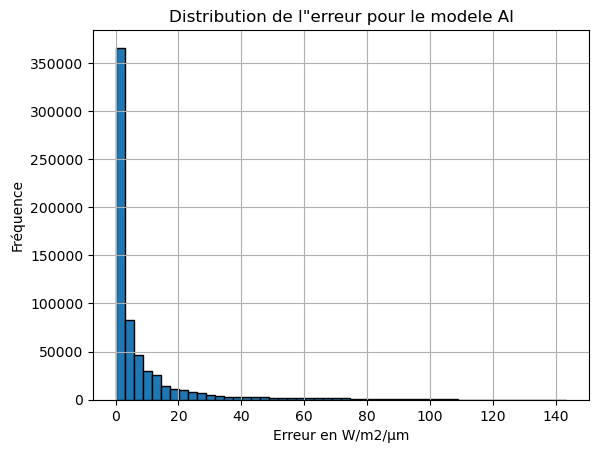

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

df_test['Erreur_AI'].plot(kind='hist', bins=50, edgecolor='black')
plt.xlabel('Erreur en W/m2/µm')
plt.ylabel('Fréquence')
plt.title('Distribution de l"erreur pour le modele AI')
plt.grid(True)
plt.show()


### Erreur Analytic :

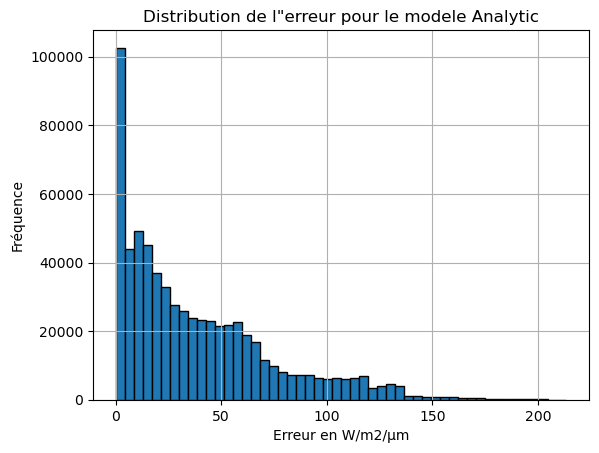

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

df_test['Erreur_Analytic'].plot(kind='hist', bins=50, edgecolor='black')
plt.xlabel('Erreur en W/m2/µm')
plt.ylabel('Fréquence')
plt.title('Distribution de l"erreur pour le modele Analytic')
plt.grid(True)
plt.show()

### Mean Absolut Error :

### AI :

In [36]:
MAE=mean_absolute_error(df_test['BOA_RT'],df_test['BOA_pred'])
MAE

8.196289819695446

In [37]:
df_test['Erreur_AI'].describe()

count    648000.000000
mean          8.196290
std          15.487792
min           0.000000
25%           0.693320
50%           2.124188
75%           7.917228
max         143.462914
Name: Erreur_AI, dtype: float64

#### Analytic :

In [38]:
MAE=mean_absolute_error(df_test['BOA_RT'],df_test['BOA_Analytic'])
MAE

38.035091289714536

In [39]:
df_test['Erreur_Analytic'].describe()

count    648000.000000
mean         38.035091
std          35.762282
min           0.000000
25%           9.892544
50%          27.606308
75%          57.005183
max         213.484532
Name: Erreur_Analytic, dtype: float64

### PLOTS :

In [63]:
import matplotlib.pyplot as plt

# Nombre de groupes
n = len(df_test) // 1000

for i in range(n):
    # Extraire le sous-DataFrame de 1000 lignes
    subset = df_test.iloc[i*1000 : (i+1)*1000]

    # Récupérer les valeurs uniques (constantes) des paramètres pour le titre
    SZA = subset['SZA'].iloc[0]
    Z = subset['Z'].iloc[0]
    R = subset['R_scene'].iloc[0]
    k_a = subset['k_a'].iloc[0]
    k_g = subset['k_g'].iloc[0]
    gaz_model = subset['gaz_model'].iloc[0]
    dl = subset['dl'].iloc[0]

    # Créer le titre dynamique
    title = f"SZA={SZA}, Z={Z}, R={R}, k_a={k_a}, k_g={k_g}, gaz_model={gaz_model}, dl={dl}"

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(subset['lamda'], subset['BOA_RT'], label='RT', color='blue')
    plt.plot(subset['lamda'], subset['BOA_pred'], label='AI', color='red')
    plt.plot(subset['lamda'], subset['BOA_Analytic'], label='Analytic', color='green')
    plt.xlabel('lambda')
    plt.ylabel('Irradiance')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Optionnel : enregistrer la figure
    plt.savefig(f"plots/plot_{i:03}.png")  # Assure-toi que le dossier "plots/" existe
    plt.close()  # Ferme la figure pour éviter de saturer la mémoire


### Loading spectral database and matching values with wave lengths :

In [41]:
s = pd.read_csv("solar_db.csv", skiprows=1)
s = s.T.reset_index()
s.columns = s.iloc[0]  
s = s[1:]    

In [42]:
s['Lambda [µm]']=s['Lambda [µm]'].astype(float)
s['Spectra properties ']=s['Spectra properties '].astype(float)

In [43]:
s.columns

Index(['Lambda [µm]', 'Spectra properties '], dtype='object', name=0)

In [44]:
s=s[(s['Lambda [µm]']>=0.4)&(s['Lambda [µm]']<=2.5)]
s

,Lambda [µm],Spectra properties
25151,0.400000,1763.5000
25152,0.400016,1764.5000
25153,0.400032,1765.4900
25154,0.400048,1766.4400
25155,0.400064,1767.4000
...,...,...
46147,2.497500,51.2223
46148,2.498130,51.3569
46149,2.498750,51.2993
46150,2.499380,51.3056


In [45]:
s.reset_index(drop=True,inplace=True)
s

,Lambda [µm],Spectra properties
0,0.400000,1763.5000
1,0.400016,1764.5000
2,0.400032,1765.4900
3,0.400048,1766.4400
4,0.400064,1767.4000
...,...,...
20996,2.497500,51.2223
20997,2.498130,51.3569
20998,2.498750,51.2993
20999,2.499380,51.3056


In [47]:
t=df_test.iloc[:1000]
t['nearest_lambda'] = t['lamda'].apply(lambda x: s.iloc[(s['Lambda [µm]'] - x).abs().argsort()[0]]['Lambda [µm]'])
t = t.merge(s, left_on='nearest_lambda', right_on='Lambda [µm]', how='left')

In [48]:
t_dup=t[['Lambda [µm]','Spectra properties ']]
new_columns= pd.concat([t_dup]*648, ignore_index=True)
new_columns

,Lambda [µm],Spectra properties
0,0.400000,1763.5000
1,0.402107,1905.4000
2,0.404204,1811.0300
3,0.406306,1687.3400
4,0.408413,1726.7100
...,...,...
647995,2.491900,51.7105
647996,2.493770,51.5528
647997,2.495630,51.3472
647998,2.498130,51.3569


In [49]:
df_test['spectral_irradiance']=new_columns['Spectra properties ']
df_test

,Tg_scat,Tg_abs,Ta_abs,SSA,GOD,AOD,AODS,SZA,Z,R_scene,...,gaz_model,dl,lamda,BOA_fraction,BOA_fraction_pred,BOA_pred,BOA_Analytic,Erreur_AI,Erreur_Analytic,spectral_irradiance
0,0.700200,0.996600,0.979400,0.953056,0.356389,0.443408,0.422593,15,0,0.1,...,USSTD76,0.00,0.400000,0.824055,0.825226,825.226013,775.606080,1.171204,48.448729,1763.5000
1,0.705600,0.997200,0.979400,0.952816,0.348707,0.441144,0.420329,15,0,0.1,...,USSTD76,0.00,0.402102,0.827342,0.828582,828.582153,778.794349,1.240569,48.547235,1905.4000
2,0.710887,0.996500,0.979500,0.952798,0.341241,0.438815,0.418102,15,0,0.1,...,USSTD76,0.00,0.404204,0.829523,0.830488,830.488220,780.958660,0.965435,48.564125,1811.0300
3,0.716009,0.997491,0.979600,0.952797,0.334063,0.436646,0.416035,15,0,0.1,...,USSTD76,0.00,0.406306,0.833131,0.834211,834.211426,784.403183,1.080201,48.728042,1687.3400
4,0.721100,0.996700,0.979700,0.952797,0.326977,0.434482,0.413973,15,0,0.1,...,USSTD76,0.00,0.408408,0.835112,0.835907,835.907471,786.383972,0.795273,48.728226,1726.7100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647995,0.999800,0.021037,0.988688,0.822761,0.000200,0.064186,0.052810,60,1000,0.7,...,TROPICAL,0.06,2.491592,0.008341,0.007662,7.662139,0.987027,0.678388,7.353500,51.7105
647996,0.999800,0.017364,0.988614,0.821566,0.000200,0.064177,0.052726,60,1000,0.7,...,TROPICAL,0.06,2.493694,0.006589,0.007058,7.057570,0.700578,0.468602,5.888390,51.5528
647997,0.999800,0.016097,0.988534,0.820287,0.000200,0.064170,0.052638,60,1000,0.7,...,TROPICAL,0.06,2.495796,0.006004,0.006933,6.932936,0.611886,0.929219,5.391831,51.3472
647998,0.999800,0.010019,0.988447,0.818911,0.000200,0.064169,0.052549,60,1000,0.7,...,TROPICAL,0.06,2.497898,0.003356,0.005876,5.875788,0.262350,2.519794,3.093644,51.3569


### Evaluation using spectral data base :

In [50]:
df_test['BOA_pred_sdb']=df_test['BOA_fraction_pred']*df_test['spectral_irradiance']
df_test['BOA_RT_sdb']=df_test['BOA_fraction']*df_test['spectral_irradiance']

In [51]:
def calculate_BOA_Analytic(Tg_abs,Mg,Ta_abs,Ma,delta_g_scat,AODS,irradiance):
    numerator= irradiance*(Tg_abs**Mg)*(Ta_abs**Ma)
    denominator=1+0.5*delta_g_scat*Mg+(0.5*(1/3)*AODS)*Ma
    
    BOA_analytic= numerator / denominator
    return BOA_analytic

In [52]:
df_test['BOA_Analytic_sdb'] = df_test.apply(lambda row: calculate_BOA_Analytic(row['Tg_abs'], row['mprime_g'],row['Ta_abs'],row['mprime_a'],row['GOD'],row['AODS'],row['spectral_irradiance']), axis=1)

In [53]:
df_test

,Tg_scat,Tg_abs,Ta_abs,SSA,GOD,AOD,AODS,SZA,Z,R_scene,...,BOA_fraction,BOA_fraction_pred,BOA_pred,BOA_Analytic,Erreur_AI,Erreur_Analytic,spectral_irradiance,BOA_pred_sdb,BOA_RT_sdb,BOA_Analytic_sdb
0,0.700200,0.996600,0.979400,0.953056,0.356389,0.443408,0.422593,15,0,0.1,...,0.824055,0.825226,825.226013,775.606080,1.171204,48.448729,1763.5000,1455.286067,1453.220656,1367.781323
1,0.705600,0.997200,0.979400,0.952816,0.348707,0.441144,0.420329,15,0,0.1,...,0.827342,0.828582,828.582153,778.794349,1.240569,48.547235,1905.4000,1578.780462,1576.416654,1483.914753
2,0.710887,0.996500,0.979500,0.952798,0.341241,0.438815,0.418102,15,0,0.1,...,0.829523,0.830488,830.488220,780.958660,0.965435,48.564125,1811.0300,1504.039054,1502.290649,1414.339563
3,0.716009,0.997491,0.979600,0.952797,0.334063,0.436646,0.416035,15,0,0.1,...,0.833131,0.834211,834.211426,784.403183,1.080201,48.728042,1687.3400,1407.598279,1405.775641,1323.554867
4,0.721100,0.996700,0.979700,0.952797,0.326977,0.434482,0.413973,15,0,0.1,...,0.835112,0.835907,835.907471,786.383972,0.795273,48.728226,1726.7100,1443.369769,1441.996583,1357.857069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647995,0.999800,0.021037,0.988688,0.822761,0.000200,0.064186,0.052810,60,1000,0.7,...,0.008341,0.007662,7.662139,0.987027,0.678388,7.353500,51.7105,0.396213,0.431293,0.051040
647996,0.999800,0.017364,0.988614,0.821566,0.000200,0.064177,0.052726,60,1000,0.7,...,0.006589,0.007058,7.057570,0.700578,0.468602,5.888390,51.5528,0.363837,0.339680,0.036117
647997,0.999800,0.016097,0.988534,0.820287,0.000200,0.064170,0.052638,60,1000,0.7,...,0.006004,0.006933,6.932936,0.611886,0.929219,5.391831,51.3472,0.355987,0.308274,0.031419
647998,0.999800,0.010019,0.988447,0.818911,0.000200,0.064169,0.052549,60,1000,0.7,...,0.003356,0.005876,5.875788,0.262350,2.519794,3.093644,51.3569,0.301762,0.172353,0.013473


### Erreur AI SDB :

In [54]:
df_test['Erreur_AI_sdb']=np.abs(df_test['BOA_pred_sdb']-df_test['BOA_RT_sdb'])
df_test['Erreur_Analytic_sdb']=np.abs(df_test['BOA_Analytic_sdb']-df_test['BOA_RT_sdb'])

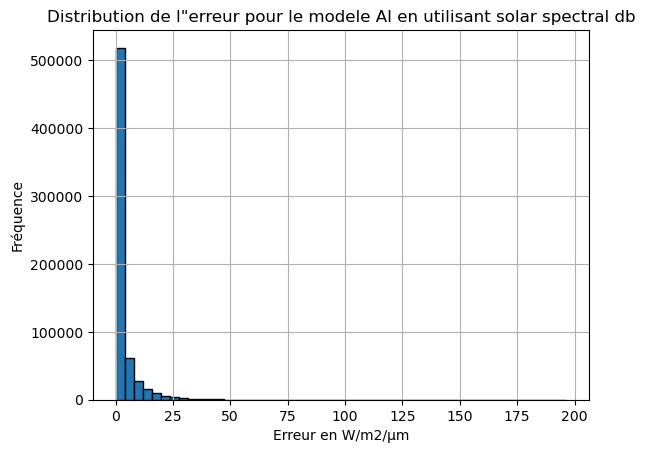

In [55]:
df_test['Erreur_AI_sdb'].plot(kind='hist', bins=50, edgecolor='black')
plt.xlabel('Erreur en W/m2/µm')
plt.ylabel('Fréquence')
plt.title('Distribution de l"erreur pour le modele AI en utilisant solar spectral db')
plt.grid(True)
plt.show()

In [56]:
MAE=mean_absolute_error(df_test['BOA_RT_sdb'],df_test['BOA_pred_sdb'])
MAE

2.937845647224337

In [58]:
df_test['Erreur_AI_sdb'].describe()

count    648000.000000
mean          2.937846
std           5.934480
min           0.000000
25%           0.201742
50%           0.768907
75%           2.965365
max         196.496845
Name: Erreur_AI_sdb, dtype: float64

### Erreur Analytic SDB :

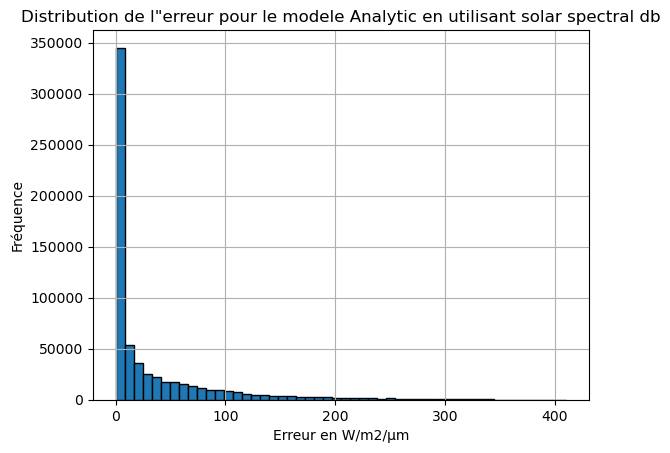

In [59]:
df_test['Erreur_Analytic_sdb'].plot(kind='hist', bins=50, edgecolor='black')
plt.xlabel('Erreur en W/m2/µm')
plt.ylabel('Fréquence')
plt.title('Distribution de l"erreur pour le modele Analytic en utilisant solar spectral db')
plt.grid(True)
plt.show()

In [60]:
MAE=mean_absolute_error(df_test['BOA_RT_sdb'],df_test['BOA_Analytic_sdb'])
MAE

33.798493881546726

### Plots :

In [61]:
df_test

,Tg_scat,Tg_abs,Ta_abs,SSA,GOD,AOD,AODS,SZA,Z,R_scene,...,BOA_pred,BOA_Analytic,Erreur_AI,Erreur_Analytic,spectral_irradiance,BOA_pred_sdb,BOA_RT_sdb,BOA_Analytic_sdb,Erreur_AI_sdb,Erreur_Analytic_sdb
0,0.700200,0.996600,0.979400,0.953056,0.356389,0.443408,0.422593,15,0,0.1,...,825.226013,775.606080,1.171204,48.448729,1763.5000,1455.286067,1453.220656,1367.781323,2.065411,85.439333
1,0.705600,0.997200,0.979400,0.952816,0.348707,0.441144,0.420329,15,0,0.1,...,828.582153,778.794349,1.240569,48.547235,1905.4000,1578.780462,1576.416654,1483.914753,2.363808,92.501901
2,0.710887,0.996500,0.979500,0.952798,0.341241,0.438815,0.418102,15,0,0.1,...,830.488220,780.958660,0.965435,48.564125,1811.0300,1504.039054,1502.290649,1414.339563,1.748405,87.951086
3,0.716009,0.997491,0.979600,0.952797,0.334063,0.436646,0.416035,15,0,0.1,...,834.211426,784.403183,1.080201,48.728042,1687.3400,1407.598279,1405.775641,1323.554867,1.822638,82.220775
4,0.721100,0.996700,0.979700,0.952797,0.326977,0.434482,0.413973,15,0,0.1,...,835.907471,786.383972,0.795273,48.728226,1726.7100,1443.369769,1441.996583,1357.857069,1.373186,84.139515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647995,0.999800,0.021037,0.988688,0.822761,0.000200,0.064186,0.052810,60,1000,0.7,...,7.662139,0.987027,0.678388,7.353500,51.7105,0.396213,0.431293,0.051040,0.035080,0.380253
647996,0.999800,0.017364,0.988614,0.821566,0.000200,0.064177,0.052726,60,1000,0.7,...,7.057570,0.700578,0.468602,5.888390,51.5528,0.363837,0.339680,0.036117,0.024158,0.303563
647997,0.999800,0.016097,0.988534,0.820287,0.000200,0.064170,0.052638,60,1000,0.7,...,6.932936,0.611886,0.929219,5.391831,51.3472,0.355987,0.308274,0.031419,0.047713,0.276855
647998,0.999800,0.010019,0.988447,0.818911,0.000200,0.064169,0.052549,60,1000,0.7,...,5.875788,0.262350,2.519794,3.093644,51.3569,0.301762,0.172353,0.013473,0.129409,0.158880


In [62]:
import matplotlib.pyplot as plt

# Nombre de groupes
n = len(df_test) // 1000

for i in range(n):
    # Extraire le sous-DataFrame de 1000 lignes
    subset = df_test.iloc[i*1000 : (i+1)*1000]

    # Récupérer les valeurs uniques (constantes) des paramètres pour le titre
    SZA = subset['SZA'].iloc[0]
    Z = subset['Z'].iloc[0]
    R = subset['R_scene'].iloc[0]
    k_a = subset['k_a'].iloc[0]
    k_g = subset['k_g'].iloc[0]
    gaz_model = subset['gaz_model'].iloc[0]
    dl = subset['dl'].iloc[0]

    # Créer le titre dynamique
    title = f"SZA={SZA}, Z={Z}, R={R}, k_a={k_a}, k_g={k_g}, gaz_model={gaz_model}, dl={dl}"

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(subset['lamda'], subset['BOA_RT_sdb'], label='RT', color='blue')
    plt.plot(subset['lamda'], subset['BOA_pred_sdb'], label='AI', color='red')
    plt.plot(subset['lamda'], subset['BOA_Analytic_sdb'], label='Analytic', color='green')
    plt.xlabel('lambda')
    plt.ylabel('Irradiance')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Optionnel : enregistrer la figure
    plt.savefig(f"plots_sdb/plot_{i:03}.png")  # Assure-toi que le dossier "plots/" existe
    plt.close()  # Ferme la figure pour éviter de saturer la mémoire
